In [1]:
#import ee
#import geemap
import hvplot.pandas
#import hvplot.xarray
#import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely
import os
from pathlib import Path

In [6]:
ee.Authenticate()

True

In [2]:
Map = geemap.Map(center=(40, -100), zoom=4)
Map.add_basemap("HYBRID")
Map

NameError: name 'geemap' is not defined

## 1. Prep DSMP Data

In [6]:
# Load data from DSMP surves
paths_data_q = list(Path(f'../mrc_webscrapper/outputs/csv/Sediment Concentration/').glob(f'*.csv'))
paths_data_s = list(Path(f'../mrc_webscrapper/outputs/csv/Discharge/').glob(f'*.csv'))
paths_data = paths_data_q + paths_data_s
df_data = pd.DataFrame([])
for path in paths_data:
    df_temp = pd.read_csv(path, dtype={'station_code':'str'})
    df_temp['date'] = pd.to_datetime(df_temp['date'])
    df_temp['med_frq'] = np.median(np.diff(df_temp.date))
    
    df_data = pd.concat([df_data, df_temp])


df_data_dsmp = df_data.loc[df_data.identifier.str.contains('DSMP')]
df_dsmp_stations = df_data_dsmp.groupby('station_code').first()
df_data_dsmp = df_data.loc[df_data.station_code.isin(df_dsmp_stations.index)]
    
gdf_stations = gpd.GeoDataFrame(df_dsmp_stations,
                 crs={'init': 'epsg:4326'},
                 geometry=df_dsmp_stations.apply(lambda row: shapely.geometry.Point((row.lon, row.lat)), axis=1)
                )

C:\ProgramData\Anaconda3\envs\earth-engine\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Plot DSMP stations on map

In [495]:
# gdf_labels = gdf_stations.groupby('station_name').first().reset_index().set_crs("EPSG:4326").to_crs("EPSG:3857")
# gdf_labels['latitude_3857'] = gdf_labels.geometry.apply(lambda x: x.coords[0][1])
# gdf_labels['longitude_3857'] = gdf_labels.geometry.apply(lambda x: x.coords[0][0])
# labels = gdf_labels.hvplot.labels(x='longitude_3857', y='latitude_3857', text="station_name", text_color='black')

# gdf_stations.hvplot.points(geo=True, tiles='OSM', color='red', hover_cols=['station_name']) *\
#     labels

In [ ]:
from shapely import wkt
import time

# Load DSMP station coords from Final Report
path_csv = Path('mrc_data/dsmp_stations.csv')
df_dsmp_stations_coords = pd.read_csv(path_csv, delimiter=';')

path_transects = Path('mrc_data/dsmp_transects_drawn.csv')
if not(path_transects.exists()):
    transects = []
    stations = []
    for idx, row in df_dsmp_stations.iterrows():
        match = df_dsmp_stations_coords.loc[df_dsmp_stations_coords['Station code']==row.name]
        lon, lat = row.lon, row.lat
        
        if not(match.empty):
            lat, lon = float(match.Latitude.values), float(match.Longitude.values)
        print(f'({row.name}): ({lon}, {lat})')
        ee_station = ee.Feature(ee.Algorithms.GeometryConstructors.Point([lon, lat]), {'station_id': row.name, 'station_name': row.station_name})
        stations.append(ee_station)
        Map.addLayer(ee_station, {'color': 'red'}, row.station_name)
        Map.centerObject(ee_station, 10)
        
        wait = True
        while wait: 
            if input('Transect added? (y/n)').lower()=='y': 
                wait = False    

    for idx, station in enumerate(stations):
        drawn_geom = Map.draw_features[idx].geometry()
        ee_transect = stations[idx].setGeometry(drawn_geom)
        transects.append(ee_transect)
        
    ee_transects = ee.FeatureCollection(transects)
    gdf_transects = geemap.ee_to_gdf(ee_transects).reset_index(drop=True)
    gdf_transects.to_csv('mrc_data/dsmp_transects_drawn.csv')
        
else:
    path_transects = Path('mrc_data/dsmp_transects_drawn.csv')
    df = pd.read_csv(path_transects)
    gdf_transects =  gpd.GeoDataFrame(df, geometry=df['geometry'].apply(wkt.loads), crs='epsg:4326')
    ee_transects = geemap.gdf_to_ee(gdf_transects)

Map.addLayer(ee_transects, {'color':'red'}, 'Transects')
Map.centerObject(ee_stations)

In [3]:
for idx, row in df_dsmp_stations.iterrows():
    station_name = row.station_name
    station_code = idx
    print(f'({station_code}) {station_name}')
    df_temp = df_data.loc[df_data.station_code==station_code]
    df_dsmp_q = df_temp.loc[df_temp.identifier.str.contains('DSMP') & (df_temp.parameter=='Discharge')]
    df_dsmp_s = df_temp.loc[df_temp.identifier.str.contains('DSMP') & (df_temp.parameter=='Sediment Concentration')]
    df_wqm_q = df_temp.loc[~df_temp.identifier.str.contains('DSMP') & (df_temp.parameter=='Sediment Concentration')]
    
    # save datasets for each station
    path_csv = Path(f'mrc_data/{station_code}')
    path_csv.mkdir(parents=True, exist_ok=True)
    df_dsmp_q.to_csv(f'mrc_data/{station_code}/{station_code}_DSMP_Q.csv')
    df_dsmp_s.to_csv(f'mrc_data/{station_code}/{station_code}_DSMP_S.csv')
    df_wqm_q.to_csv(f'mrc_data/{station_code}/{station_code}_WMQ_Q.csv')

(010501) Chiang Saen
(011903) Chiang Khan
(012001) Nong Khai
(013101) Nakhon Phanom
(013402) Mukdahan
(013801) Khong Chiam
(013901) Pakse
(014501) Stung Treng
(014901) Kratie
(019801) Chroy Chang Var
(019803) Tan Chau
(020102) Prek Kdam
(039801) Chau Doc
(KNR) Koh Norea
(OSP) OSP-MRC
(SKB) Sekong Bridge


## 2. Get EO data

In [4]:
kwargs = {
}
# Set timespan
start_date, end_date = '2000-01-01', '2024-01-30'
# Cloud masking (scene-based)
cld_filt_thresh = 80        # Maximum image cloud cover percent allowed in image collection
# water masking
mask_water = True
# Cloud masking (pixel-based, cloud score+ only)
qa_band = 'cs_cdf'
clear_thresh = 0.65

In [1368]:
%load_ext autoreload
%autoreload 2
import functions_process as funcs_process
import functions_turbidity as funcs_turb
import functions_sampling as funcs_sampling

buffer = 90
stations = ee_transects.map(lambda x: x.setGeometry(x.geometry().buffer(buffer)))
Map.addLayer(stations, {'color': 'yellow'}, 'Sampling sites')

for idx, row in geemap.ee_to_df(stations).iterrows():
    name, id = row.station_name, row.station_id
    print(f'{name} ({id})')
    station = stations.filter(ee.Filter.eq('station_id', id))
    station = station
    
    # get Rrs imagecolls
    ic_msi = funcs_process.load_sr_imcoll(sensor='msi', start_date=start_date, end_date=end_date, mask_water=mask_water, bounds=station)
    ic_oli = funcs_process.load_sr_imcoll(sensor='oli', start_date=start_date, end_date=end_date, mask_water=mask_water, bounds=station)
    ic_etm = funcs_process.load_sr_imcoll(sensor='etm', start_date=start_date, end_date=end_date, mask_water=mask_water, bounds=station)
    ic_all = ic_msi.merge(ic_oli).merge(ic_etm)
    
    # compute tsm features
    ic_all = ic_all \
        .map(funcs_turb.calc_indices) \
        .map(funcs_turb.calc_band_ratios)

    # merge imagecolls and sample
    fc_all = ee.FeatureCollection(ic_all.map(funcs_sampling.sample_image(station))).flatten()

    # export to drive
    geemap.ee_export_vector_to_drive(
        fc_all.filter(ee.Filter.gt('roi_coverage', 90)),
        fileFormat='CSV', 
        folder="export_mekong_points_sr",
        description=f"sr_samples_{name.replace(' ', '').lower()}_{id}", 
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Chiang Saen (010501)
Exporting sr_samples_chiangsaen_010501... Please check the Task Manager from the JavaScript Code Editor.
Chiang Khan (011903)
Exporting sr_samples_chiangkhan_011903... Please check the Task Manager from the JavaScript Code Editor.
Nong Khai (012001)
Exporting sr_samples_nongkhai_012001... Please check the Task Manager from the JavaScript Code Editor.
Nakhon Phanom (013101)
Exporting sr_samples_nakhonphanom_013101... Please check the Task Manager from the JavaScript Code Editor.
Mukdahan (013402)
Exporting sr_samples_mukdahan_013402... Please check the Task Manager from the JavaScript Code Editor.
Khong Chiam (013801)
Exporting sr_samples_khongchiam_013801... Please check the Task Manager from the JavaScript Code Editor.
Pakse (013901)
Exporting sr_samples_pakse_013901... Please check the Task Manager from the JavaScript Code Editor.
Stung Treng (014501)
Exporting sr_samples_stun

In [111]:
import datetime

pd_parser = lambda x: pd.to_datetime(x).tz_convert(None) if pd.to_datetime(x).tzinfo else pd.to_datetime(x)

df_rs_all = pd.DataFrame([])
df_dsmp_s_all = pd.DataFrame([])
for idx, row in df_dsmp_stations.iterrows():
    station_name = row.station_name
    station_code = idx
    df_rs = pd.read_csv(f'mrc_data/rrs_samples/rrs_samples_{''.join(station_name.lower().split())}_{station_code}.csv', parse_dates=['timestamp'], date_parser=pd_parser)
    df_rs = df_rs.set_index('timestamp')
    
    df_dsmp_q = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_Q.csv', parse_dates=['date'], date_parser=pd_parser)
    df_dsmp_q_interp = df_dsmp_q[['date', 'value']].set_index('date').resample('1d').mean().interpolate(limit=7)
    
    df_dsmp_s = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_S.csv', parse_dates=['date'], date_parser=pd_parser).set_index('date')
    df_dsmp_s_interp = df_dsmp_s[['value']].resample('1d').mean().interpolate(limit=7)
    
    df_wqm_q = pd.read_csv(f'mrc_data/{station_code}/{station_code}_WMQ_Q.csv', parse_dates=['date'], date_parser=pd_parser)

    # create matchups
    df_s = df_dsmp_s.copy()
    delta_dt_dry = 24 # hours
    delta_dt_wet = 24
    
    n_matchups = 0
    for idx, row in df_rs.iterrows():
        timestamp = row.name
        delta_dt = delta_dt_wet if (timestamp.month in [6,7,8,9,10,11]) else delta_dt_dry
        t_start = timestamp - datetime.timedelta(hours=delta_dt)
        t_end = timestamp + datetime.timedelta(hours=delta_dt)
        matches = df_s.loc[(df_s.index <= t_end) & (df_s.index >= t_start)]
        
        if matches.shape[0] == 0:
            value = np.nan
            dt = pd.Timestamp('NaT')
            dt_diff = pd.Timestamp('NaT')
        elif matches.shape[0] == 1:
            value = matches.iloc[0].value
            dt = matches.iloc[0].name
            dt_diff = abs(pd.to_datetime(matches.iloc[0].name)-timestamp)
            n_matchups += 1
        else:
            matches.loc[:, 'dt_diff'] = abs(pd.to_datetime(matches.iloc[0].name)-timestamp)
            matches = matches.sort_values('dt_diff')
            value = matches.iloc[0].value 
            dt = matches.iloc[0].name
            dt_diff = matches.iloc[0].dt_diff
            n_matchups += 1


        df_rs.loc[idx, 'season'] = 'wet' if (timestamp.month in [6,7,8,9,10,11]) else 'dry'
        df_rs.loc[idx, 's'] = value
        df_rs.loc[idx, 'dt_s'] = dt
        df_rs.loc[idx, 'dt_diff'] = dt_diff

    print(f'Found {n_matchups} for {station_name} ({station_code})')
    df_rs['station_code'] = station_code
    df_rs['station_name'] = station_name
    df_rs_all = pd.concat([df_rs_all, df_rs])
    df_dsmp_s_all = pd.concat([df_dsmp_s_all, df_dsmp_s])

C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_rs = pd.read_csv(f'mrc_data/rrs_samples/rrs_samples_{''.join(station_name.lower().split())}_{station_code}.csv', parse_dates=['timestamp'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_dsmp_q = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_Q.csv', parse_dates=['date'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Pleas

Found 3 for Chiang Saen (010501)


C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_dsmp_q = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_Q.csv', parse_dates=['date'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_dsmp_s = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_S.csv', parse_dates=['date'], date_parser=pd_parser).set_index('date')
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:19: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' inste

Found 5 for Chiang Khan (011903)
Found 4 for Nong Khai (012001)


C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_rs = pd.read_csv(f'mrc_data/rrs_samples/rrs_samples_{''.join(station_name.lower().split())}_{station_code}.csv', parse_dates=['timestamp'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_dsmp_q = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_Q.csv', parse_dates=['date'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Pleas

Found 3 for Nakhon Phanom (013101)


C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_rs = pd.read_csv(f'mrc_data/rrs_samples/rrs_samples_{''.join(station_name.lower().split())}_{station_code}.csv', parse_dates=['timestamp'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_dsmp_q = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_Q.csv', parse_dates=['date'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Pleas

Found 5 for Mukdahan (013402)


C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_rs = pd.read_csv(f'mrc_data/rrs_samples/rrs_samples_{''.join(station_name.lower().split())}_{station_code}.csv', parse_dates=['timestamp'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_dsmp_q = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_Q.csv', parse_dates=['date'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Pleas

Found 8 for Khong Chiam (013801)


C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_rs = pd.read_csv(f'mrc_data/rrs_samples/rrs_samples_{''.join(station_name.lower().split())}_{station_code}.csv', parse_dates=['timestamp'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_dsmp_q = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_Q.csv', parse_dates=['date'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Pleas

Found 2 for Pakse (013901)


C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_rs = pd.read_csv(f'mrc_data/rrs_samples/rrs_samples_{''.join(station_name.lower().split())}_{station_code}.csv', parse_dates=['timestamp'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_dsmp_q = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_Q.csv', parse_dates=['date'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Pleas

Found 11 for Stung Treng (014501)


C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_rs = pd.read_csv(f'mrc_data/rrs_samples/rrs_samples_{''.join(station_name.lower().split())}_{station_code}.csv', parse_dates=['timestamp'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_dsmp_q = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_Q.csv', parse_dates=['date'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Pleas

Found 9 for Kratie (014901)


C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_rs = pd.read_csv(f'mrc_data/rrs_samples/rrs_samples_{''.join(station_name.lower().split())}_{station_code}.csv', parse_dates=['timestamp'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_dsmp_q = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_Q.csv', parse_dates=['date'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Pleas

Found 5 for Chroy Chang Var (019801)


C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_rs = pd.read_csv(f'mrc_data/rrs_samples/rrs_samples_{''.join(station_name.lower().split())}_{station_code}.csv', parse_dates=['timestamp'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_dsmp_q = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_Q.csv', parse_dates=['date'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Pleas

Found 14 for Tan Chau (019803)


C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_dsmp_q = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_Q.csv', parse_dates=['date'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_dsmp_s = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_S.csv', parse_dates=['date'], date_parser=pd_parser).set_index('date')
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:19: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' inste

Found 5 for Prek Kdam (020102)
Found 8 for Chau Doc (039801)


C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_rs = pd.read_csv(f'mrc_data/rrs_samples/rrs_samples_{''.join(station_name.lower().split())}_{station_code}.csv', parse_dates=['timestamp'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_dsmp_q = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_Q.csv', parse_dates=['date'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Pleas

Found 4 for Koh Norea (KNR)


C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_rs = pd.read_csv(f'mrc_data/rrs_samples/rrs_samples_{''.join(station_name.lower().split())}_{station_code}.csv', parse_dates=['timestamp'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_dsmp_q = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_Q.csv', parse_dates=['date'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Pleas

Found 3 for OSP-MRC (OSP)


C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_rs = pd.read_csv(f'mrc_data/rrs_samples/rrs_samples_{''.join(station_name.lower().split())}_{station_code}.csv', parse_dates=['timestamp'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_dsmp_q = pd.read_csv(f'mrc_data/{station_code}/{station_code}_DSMP_Q.csv', parse_dates=['date'], date_parser=pd_parser)
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\255714612.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Pleas

Found 10 for Sekong Bridge (SKB)


In [53]:
data = df_rs_all.copy()
data = data.loc[data.CLOUD_COVER<85]
data = data.loc[data.cloudiness_500m<0.2]
data = data.loc[~np.isnan(data.s)]
data = data.loc[data.s < 700]
method = 'q_bin'
data['q_bin'] = pd.qcut(data['s'], q=5, duplicates='drop')
data['c_bin'] = pd.cut(data['s'], 4, duplicates='drop')
min_group_sz = data.groupby(method).count()['system:time_start'].min()
print(min_group_sz)
data_strat = data.groupby(method).apply(lambda x: x.sample(n=50, replace=True))

28


C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\1271598588.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  min_group_sz = data.groupby(method).count()['system:time_start'].min()
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\1271598588.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_strat = data.groupby(method).apply(lambda x: x.sample(n=50, replace=True))
C:\Users\Michael\AppData\Local\Temp\ipykernel_11556\1271598588.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns wil

p0: (-0.08500375143712839, 0.21126495297436995, 0.27934356948786715)
R² = 0.3973935088634011


C:\Users\Michael\AppData\Local\Temp\ipykernel_18564\4275035748.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[idx, 'GI_tss'] = f_GI_tss(x, c0, c1, c2)
C:\Users\Michael\AppData\Local\Temp\ipykernel_18564\4275035748.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[idx, 'GI_tss'] = f_GI_tss(x, c0, c1, c2)


Text(0.5, 0, '$GI_{TSS}$')

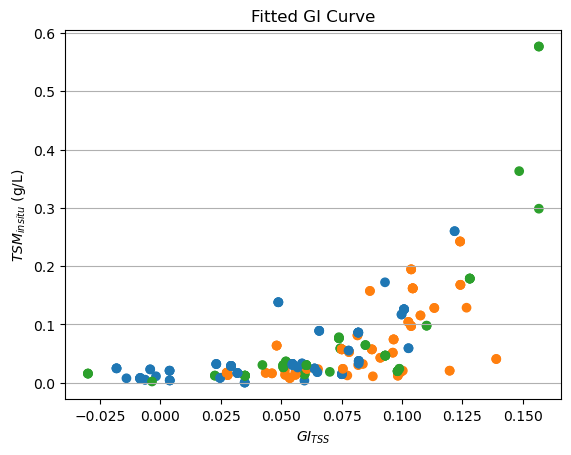

In [187]:
import scipy
import matplotlib
import matplotlib.pyplot as plt
cmap = matplotlib.colors.ListedColormap(plt.cm.tab10.colors)

data = data.loc[~np.isnan(data.s)]
data = data_strat

def f_GI_tss(x, c0, c1, c2):
    Rb, Rg, Rr, Rnir = x
    w1 = Rr/(Rr+Rnir)
    w2 = Rnir/(Rr+Rnir)
    GI_tss = c0 * (Rg/Rb) + c1 * w1 * (Rr/Rg) + c2 * w2 * (Rnir/Rg)
    return GI_tss

# get data
metric = '_mean'
Rb = data.apply(lambda x: x['B1'+metric] if str(x['platform']) == 'LANDSAT-7' else x['B2'+metric], axis=1)
Rg = data.apply(lambda x: x['B2'+metric] if str(x['platform']) == 'LANDSAT-7' else x['B3'+metric], axis=1)
Rr = data.apply(lambda x: x['B3'+metric] if str(x['platform']) == 'LANDSAT-7' else x['B4'+metric], axis=1)
Rnir = data.apply(lambda x: x['B8'+metric] if (str(x['platform']) == 'SENTINEL-2') \
                  else x['B4'+metric] if str(x['platform']) == 'LANDSAT-7' \
                  else x['B5'+metric], axis=1)

x = (Rb, Rg, Rr, Rnir)
y = data.s/1000

p0 = (-0.008699050574443059, 0.09999999910518874, 0.09999999999982088)
bounds_h = (10, 10, 10)
bounds_l = (-10, -10, -10)

# perform the fit
params, cv = scipy.optimize.curve_fit(f_GI_tss, x, y, p0, bounds=(bounds_l, bounds_h), maxfev=10000000)
c0, c1, c2 = params
print(f'p0: {c0, c1, c2}')

# determine quality of the fit
squaredDiffs = np.square(y - f_GI_tss(x, c0, c1, c2))
squaredDiffsFromMean = np.square(y - np.mean(y))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

# Calculae GITTS
for idx, row in data.iterrows():
    platform = row.platform   
    Rb = row['B1'+metric] if platform == 'LANDSAT-7' else row['B2'+metric]
    Rg = row['B2'+metric] if platform == 'LANDSAT-7' else row['B3'+metric]
    Rr = row['B3'+metric] if platform == 'LANDSAT-7' else row['B4'+metric]
    Rnir = row['B8'+metric] if platform == 'SENTINEL-2' \
        else row['B4'+metric] if platform == 'LANDSAT-7' \
        else row['B5'+metric]
    x = (Rb, Rg, Rr, Rnir)
    data.loc[idx, 'GI_tss'] = f_GI_tss(x, c0, c1, c2)    

# plot the results
colors = list(data.platform.apply(lambda x: cmap(0) if (x=='LANDSAT-8') else cmap(1) if (x=='LANDSAT-7') else cmap(2)).values)
plt.grid(which='major', axis='y', zorder=-1.0)
plt.scatter(data.GI_tss.values, y, color=colors, label="data", alpha=1)
#plt.plot(data.sort_values('GI_tss').GI_tss, data.sort_values('GI_tss').GI_tss, 'k--', label="data")
plt.title("Fitted GI Curve")
plt.ylabel(r'$TSM_{insitu}$ (g/L)')
plt.xlabel(r'$GI_{TSS}$')

In [188]:
import scipy

def powerFunc(x, a1, a2):
    return a*(x**a2)

metric = 'GI_tss'
data = data.sort_values(metric)
data = data.loc[data.s < 700]

# get data
ys = data.s
xs = data[metric]

# perform the fit
p0 = (10, 4)
bounds_h = (100, 100)
bounds_l = (1, 1)

params, cv = scipy.optimize.curve_fit(powerFunc, xs, ys, p0, bounds=(bounds_l, bounds_h), maxfev=100000)
a1, a2 = params

# determine quality of the fit
squaredDiffs = np.square(ys - powerFunc(xs, a1, a2))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f'p0: {a1, a2}')
print(f"R² = {rSquared}")
print(f'RMSE = {np.sqrt(metrics.mean_squared_error(ys, powerFunc(xs, a1, a2)))}')

# plot the results
colors = list(data.platform.apply(lambda x: cmap(0) if (x=='LANDSAT-8') else cmap(1) if (x=='LANDSAT-7') else cmap(2)).values)
plt.grid(which='major', axis='y', zorder=-1.0)
plt.scatter(xs, ys, label="data", color=colors)
plt.plot(xs, powerFunc(xs, a1, a2), 'k--', label="fitted")
plt.title("Fitted GI Curve")
plt.ylabel(r'$TSM_{insitu}$ (g/L)')
plt.xlabel(r'$GI_{TSS}$')

NameError: name 'a' is not defined

p0: (0.9999999999999999, 38.971711873118124, 25.834062657239556)
R² = 0.6703096514469868
RMSE = 43.573241658725614


Text(0.5, 0, '$GI_{TSS}$')

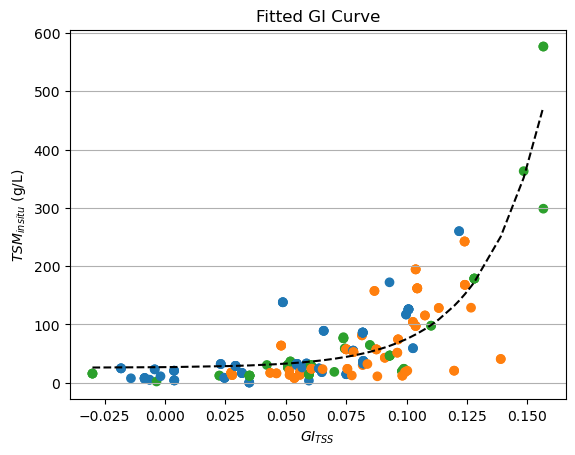

In [189]:
import scipy
from sklearn import metrics

def monoExp(x, m, t, b):
    return m * np.exp(t * x) + b

def powerFunc(x, a1, a2):
    return a*(x**a2)

metric = 'GI_tss'
data = data.sort_values(metric)
data = data.loc[data.s < 700]

# get data
ys = data.s
xs = data[metric]

# perform the fit
p0 = (1, 75, 0)
bounds_h = (1, 100, 100)
bounds_l = (-1, -0, -1)

params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0, bounds=(bounds_l, bounds_h), maxfev=100000)
m, t, b = params

# determine quality of the fit
squaredDiffs = np.square(ys - monoExp(xs, m, t, b))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f'p0: {m, t, b}')
print(f"R² = {rSquared}")
print(f'RMSE = {np.sqrt(metrics.mean_squared_error(ys, monoExp(xs, m, t, b)))}')

# plot the results
colors = list(data.platform.apply(lambda x: cmap(0) if (x=='LANDSAT-8') else cmap(1) if (x=='LANDSAT-7') else cmap(2)).values)
plt.grid(which='major', axis='y', zorder=-1.0)
plt.scatter(xs, ys, label="data", color=colors)
plt.plot(xs, monoExp(xs, m, t, b), 'k--', label="fitted")
plt.title("Fitted GI Curve")
plt.ylabel(r'$TSM_{insitu}$ (g/L)')
plt.xlabel(r'$GI_{TSS}$')

In [ ]:
def calculate_tss(df, c0, c1, c2, x, m, t, b):

    def monoExp(x, m, t, b):
        return m * np.exp(t * x) + b
    
    metric = '_mean'
    Rb = df.apply(lambda x: x['B1'+metric] if str(x['platform']) == 'LANDSAT-7' else x['B2'+metric], axis=1)
    Rg = df.apply(lambda x: x['B2'+metric] if str(x['platform']) == 'LANDSAT-7' else x['B3'+metric], axis=1)
    Rr = df.apply(lambda x: x['B3'+metric] if str(x['platform']) == 'LANDSAT-7' else x['B4'+metric], axis=1)
    Rnir = df.apply(lambda x: x['B8'+metric] if (str(x['platform']) == 'SENTINEL-2') \
                      else x['B4'+metric] if str(x['platform']) == 'LANDSAT-7' \
                      else x['B5'+metric], axis=1)
    
    w1 = Rr/(Rr+Rnir)
    w2 = Rnir/(Rr+Rnir)
    GI_tss = c0 * (Rg/Rb) + c1 * w1 * (Rr/Rg) + c2 * w2 * (Rnir/Rg)

    df['GI_tss'] = GI_tss
    df['tss_estimated'] = monoExp(GI_tss, m, t, b)
    return df

df_rs_all_out = calculate_tss(df_rs_all, c0, c1, c2, x, m, t, b)

In [41]:
from scipy import stats
from sklearn.metrics import mean_squared_error

obs = 's'
pred = 'tss_estimated'

df = df_rs_all_out.copy()
df = df.loc[~np.isnan(df[obs])]
df = df.sort_values(obs)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df[pred], df[obs])
df['y_pred'] = intercept + slope * df[obs]

# Calculate R² and RMSE
r_squared = r_value**2
rmse = np.sqrt(mean_squared_error(df[obs], df[pred]))

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df[obs], df[pred], label='Data')
plt.plot(df[obs], df['y_pred'], color='red', label='Linear regression')

# Adding text annotations for R² and RMSE
plt.text(0.05, 0.95, f'R² = {r_squared:.2f}', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.05, 0.90, f'RMSE = {rmse:.2f}', fontsize=12, transform=plt.gca().transAxes)

# Final touches
plt.ylabel(r'$TSM_{insitu}$ (g/L)')
plt.xlabel(r'$TSM_{eo}$ (g/L)')
plt.legend()
plt.show()

NameError: name 'df_rs_all_out' is not defined

In [57]:
df_rs_all_out.hvplot(y='tss_estimated', groupby='station_code') *\
df_rs_all_out.hvplot.scatter(y='tss_estimated', groupby='station_code') *\
df_dsmp_s_all.hvplot.scatter(y='value', groupby='station_code')

:DynamicMap   [station_code]
   :Overlay
      .DynamicMap.I :DynamicMap   [station_code]
         :Overlay
            .Curve.I   :Curve   [timestamp]   (tss_estimated)
            .Scatter.I :Scatter   [timestamp]   (tss_estimated)
      .Scatter.I    :Scatter   [date]   (value)

In [71]:
df = df_rs_all.copy()
df = df.loc[~np.isnan(df.s)]
metric = '_mean'
df['blue'] = df.apply(lambda x: x['B1'+metric] if str(x['platform']) == 'LANDSAT-7' else x['B2'+metric], axis=1)
df['green'] = df.apply(lambda x: x['B2'+metric] if str(x['platform']) == 'LANDSAT-7' else x['B3'+metric], axis=1)
df['red'] = df.apply(lambda x: x['B3'+metric] if str(x['platform']) == 'LANDSAT-7' else x['B4'+metric], axis=1)
df['nir'] = df.apply(lambda x: x['B8'+metric] if (str(x['platform']) == 'SENTINEL-2') \
                  else x['B4'+metric] if str(x['platform']) == 'LANDSAT-7' \
                  else x['B5'+metric], axis=1)

df_in = df[['blue', 'green', 'red', 'nir', 's']]

## XGBOOST

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

In [117]:
df = df_rs_all.copy()

# additional filters
df = df.loc[df.CLOUD_COVER<75]
df = df.loc[df.cloudiness_500m<0.2]
df = df.loc[df.s < 700]

df = df.loc[~np.isnan(df.s)]
metric = '_mean'
df['blue'] = df.apply(lambda x: x['B1'+metric] if str(x['platform']) == 'LANDSAT-7' else x['B2'+metric], axis=1)
df['green'] = df.apply(lambda x: x['B2'+metric] if str(x['platform']) == 'LANDSAT-7' else x['B3'+metric], axis=1)
df['red'] = df.apply(lambda x: x['B3'+metric] if str(x['platform']) == 'LANDSAT-7' else x['B4'+metric], axis=1)
df['nir'] = df.apply(lambda x: x['B8'+metric] if (str(x['platform']) == 'SENTINEL-2') \
                  else x['B4'+metric] if str(x['platform']) == 'LANDSAT-7' \
                  else x['B5'+metric], axis=1)

df_in = df[['blue', 'green', 'red', 'nir', 's']]

5-fold Cross-validation:
Mean MAE: 36.549 (12.310)
Tain-test-split Validation:
Mean Absolute Error: 43.37762269600565
Mean Squared Error: 5583.600843999032
Root Mean Squared Error: 74.72349592998866


C:\ProgramData\Anaconda3\envs\xgboost\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\xgboost\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


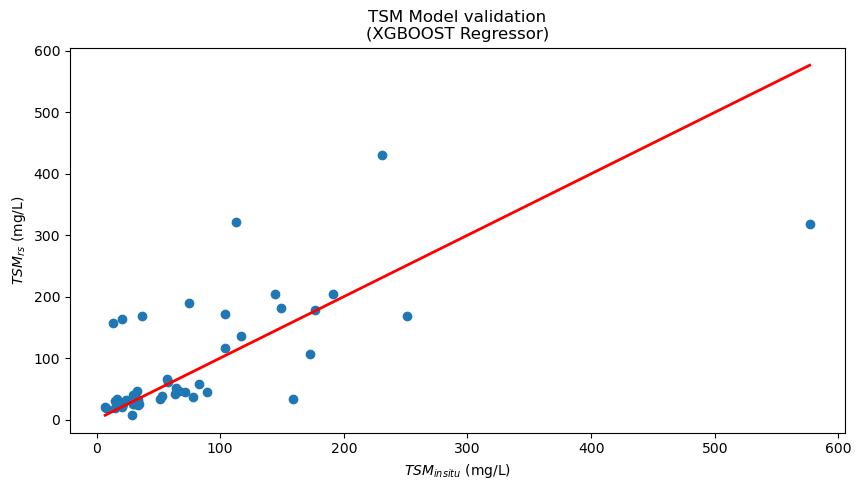

In [118]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

# prep data
obs_column = 's'
features = df._get_numeric_data().drop(columns=[obs_column, 'system:time_start', 'CLOUD_COVER'])
labels = df._get_numeric_data()[obs_column]

# Setup model
n_estimators = 100
model = xgb.XGBRegressor(n_estimators=n_estimators)

# *-*-* k-fold cv
n_splits = 5
print(f'{n_splits}-fold Cross-validation:')
cv = RepeatedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
scores = cross_val_score(model, features, labels, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

# *-*-* Train-test-split validation
print(f'Tain-test-split Validation:')

# statify splits
q_bin = pd.qcut(labels, q=25, duplicates='drop')
c_bin = pd.cut(labels, 4, duplicates='drop')

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.50, random_state=1, stratify=c_bin)
feature_names = features.columns.values

model.fit(X_train, y_train, eval_metric="error", verbose=True)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print('Mean Absolute Error:', mae)

# Calculate MSE
mse = mean_squared_error(y_test, predictions)
print('Mean Squared Error:', mse)

# Calculate RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)
print('Root Mean Squared Error:', rmse)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel(r'$TSM_{insitu}$ (mg/L)')
plt.ylabel(r'$TSM_{rs}$ (mg/L)')
plt.title('TSM Model validation\n(XGBOOST Regressor)')
plt.show()

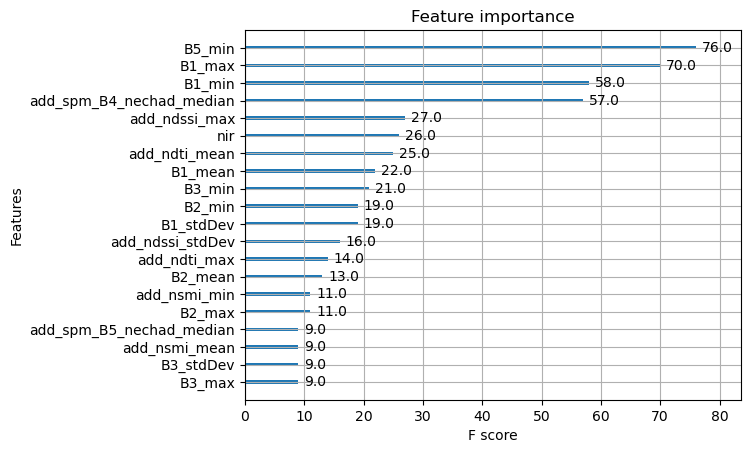

In [119]:
# plot feature importance using built-in function
from xgboost import plot_importance

plot_importance(model, max_num_features=20)
plt.show()